In [16]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    G_path = '/content/drive/MyDrive/DataSources/Project_Data'
except:
    G_path = '/content/drive/MyDrive/DataSources/Project_Data'
    
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import SubsetRandomSampler, DataLoader, SequentialSampler
import torchvision
import numpy as np
from torchvision import transforms


class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.activation = F.leaky_relu
        self.sig = torch.sigmoid
        self.pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2)
        self.normalization = nn.BatchNorm2d(3)

        #encoder
        self.conv1E = nn.Conv2d(3, 180, 4, 2)
        self.conv2E = nn.Conv2d(180, 120, 4, dilation=2)
        self.conv3E = nn.Conv2d(120, 90, 4)
        self.conv4E = nn.Conv2d(90, 60, 3, dilation=2)
        self.conv5E = nn.Conv2d(60, 30, 3)
        self.conv6E = nn.Conv2d(30, 3, 3)

        #decoder
        self.conv6D = nn.ConvTranspose2d(3, 30, 3)
        self.conv5D = nn.ConvTranspose2d(30, 60, 4)
        self.conv4D = nn.ConvTranspose2d(60, 90, 4)     
        self.conv3D = nn.ConvTranspose2d(90, 120, 4)
        self.conv2D = nn.ConvTranspose2d(120, 180, 6)
        self.conv1D = nn.ConvTranspose2d(180, 3, 6, 2)
        
    def forward(self, x):
      x = self.encode(x)
      enc = x
      x = self.decode(x)
      return x, enc

    def encode(self, x):
        x = self.normalization(x)
        x = self.activation(self.conv1E(x))
        x = self.activation(self.conv2E(x))
        x = self.activation(self.conv3E(x))
        x = self.activation(self.conv4E(x))
        x = self.activation(self.conv5E(x))
        x = self.sig(self.conv6E(x))
        return x
    
    def decode(self, x):
        x = self.activation(self.conv6D(x))
        x = self.activation(self.conv5D(x))
        x = self.activation(self.conv4D(x))
        x = self.activation(self.conv3D(x))
        x = self.activation(self.conv2D(x))
        x = self.sig(self.conv1D(x))
        return x

model = ConvAutoEncoder()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import SubsetRandomSampler, DataLoader, SequentialSampler
import torchvision
import numpy as np
from torchvision import transforms
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader

batch_size = 16
tr = torchvision.datasets.ImageFolder(root= G_path + '/01_Augmented_Imaged/train', transform=transforms.ToTensor())
val = torchvision.datasets.ImageFolder(root= G_path + '/01_Augmented_Imaged/valid', transform=transforms.ToTensor())
te = torchvision.datasets.ImageFolder(root= G_path + '/01_Augmented_Imaged/test', transform=transforms.ToTensor())

#dataset = torch.cat((tr,v,te), dim=0)
train_loader = DataLoader(dataset=ConcatDataset([tr, val, te]), shuffle=True, batch_size=batch_size , num_workers=4)

In [19]:
del tr
del val
del te

In [24]:
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

model.train()
if torch.cuda.is_available():
    print("Cuda available")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)    
print(model)

Cuda available
cuda
ConvAutoEncoder(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (normalization): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1E): Conv2d(3, 180, kernel_size=(4, 4), stride=(2, 2))
  (conv2E): Conv2d(180, 120, kernel_size=(4, 4), stride=(1, 1), dilation=(2, 2))
  (conv3E): Conv2d(120, 90, kernel_size=(4, 4), stride=(1, 1))
  (conv4E): Conv2d(90, 60, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
  (conv5E): Conv2d(60, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv6E): Conv2d(30, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv6D): ConvTranspose2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv5D): ConvTranspose2d(30, 60, kernel_size=(4, 4), stride=(1, 1))
  (conv4D): ConvTranspose2d(60, 90, kernel_size=(4, 4), stride=(1, 1))
  (conv3D): ConvTranspose2d(90, 120, kernel_size=(4, 4), stride=(1, 1))
  (conv2D): C

[0,     9] loss: 0.586
torch.Size([16, 3, 207, 282])


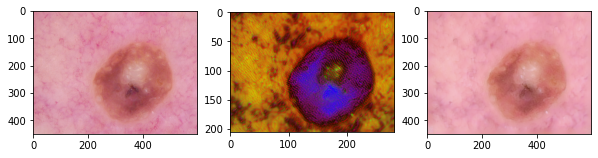

[0,    19] loss: 0.594
torch.Size([16, 3, 207, 282])


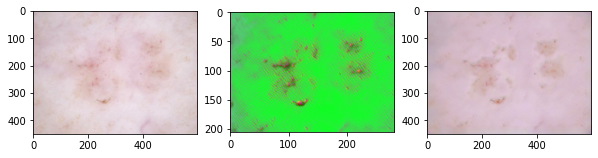

[0,    29] loss: 0.590
torch.Size([16, 3, 207, 282])


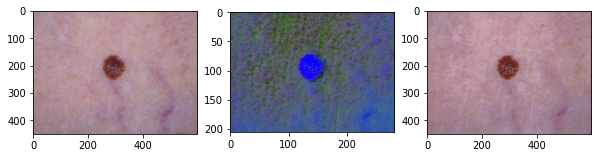

[0,    39] loss: 0.592
torch.Size([16, 3, 207, 282])


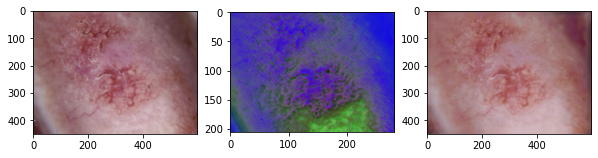

[0,    49] loss: 0.595
torch.Size([16, 3, 207, 282])


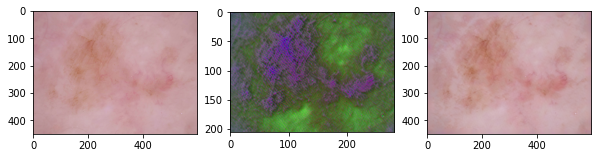

KeyboardInterrupt: ignored

In [25]:
iter = 0
for epoch in range(200):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = inputs #for make the autoenc

        optimizer.zero_grad()

        outputs, encoded = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        iter += 1

        if i % 50 == 49:
            #path of the already trained ConvAutoenc "/content/drive/MyDrive/CAE_NoPool"
            torch.save(model.state_dict(), G_path + '/08_Saved_Models_Outpus/AutoEncoder')
            print(f'[{epoch}, {i:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
            iter = 0
            print(np.shape(encoded))
            fig, axs = plt.subplots(1, 3, figsize=(10, 10))
            axs[0].imshow(inputs[0].cpu().detach().permute(1,2,0).numpy())
            axs[1].imshow(encoded[0].cpu().detach().permute(1,2,0).numpy())
            axs[2].imshow(outputs[0].cpu().detach().permute(1,2,0).numpy())
            plt.show()

print('Finished Training')

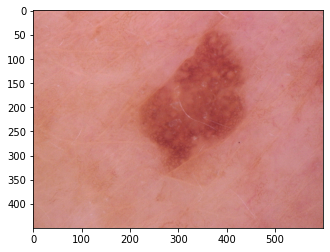

In [26]:
img = inputs[0].cpu().detach().permute(1,2,0).numpy()
plt.imshow(img)

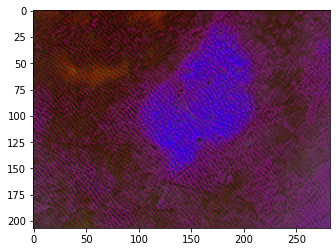

In [27]:
img = encoded[0].cpu().detach().permute(1,2,0).numpy()
plt.imshow(img)

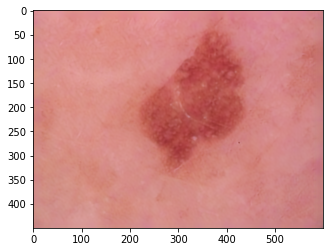

In [28]:
img = outputs[0].cpu().detach().permute(1,2,0).numpy()
plt.imshow(img)